# Tutorial 6b - Introduction to Polarization

### July 2024

This tutorial introduces the concept of polarization in Optiland. In particular, we will first assess how coatings in an optical system can impact the transmission when polarization effects are considered. Then, we will analyze the transmission of an optical system as a function of the input polarization state.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from optiland.rays import PolarizationState, create_polarization
from optiland.samples.objectives import ObjectiveUS008879901

We will use an objective consisting of 12 lens elements for this tutorial:

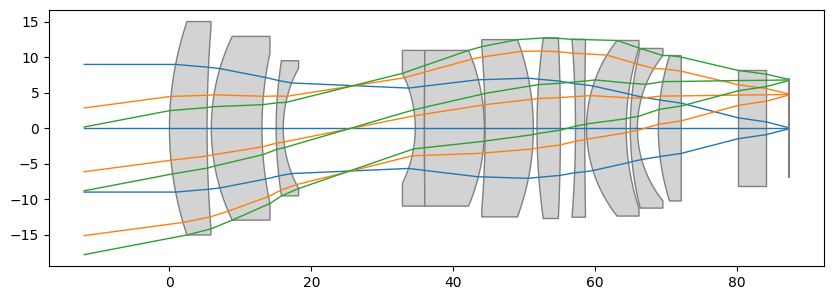

In [2]:
lens = ObjectiveUS008879901()
lens.draw()

### Remarks on polarization in Optiland:
- By default, polarization is entirely ignored
- There are 3 options for polarization in Optiland:
    1. Ignore polarization entirely
    2. Consider a specific polarization state
    3. Use unpolarized light

These are listed approximately in their order of computation speed, as each subsequent type requires more calculations. Using unpolarized light requires two orthogonal polarization states to be considered and the average transmission of both states is used to update ray transmission.

More information can be found in the Optiland documentation. Let's now start analyzing our system.

To begin, we will create a helper function that plots transmission through our lens (object to image) at the aperture stop level. Plotting the transmission in this way enables us to see pupil-dependent transmission variations.

In [3]:
def plot_transmission(lens):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot for Hy=0
    rays = lens.trace(Hx=0, Hy=0, wavelength=0.5875618, num_rays=256, distribution='uniform')
    stop_idx = lens.surface_group.stop_index
    x_stop = lens.surface_group.x[stop_idx, :]
    y_stop = lens.surface_group.y[stop_idx, :]
    r_max = np.max(np.sqrt(x_stop**2 + y_stop**2))
    x_stop /= r_max
    y_stop /= r_max
    axs[0].scatter(x_stop, y_stop, c=np.around(rays.i, 4), s=5)  # round to 4 decimals to ignore glass absorption variations, which are on the scale of 1e-6
    axs[0].axis('equal')
    axs[0].set_xlabel('Pupil X')
    axs[0].set_ylabel('Pupil Y')
    axs[0].set_title('Pupil-level Transmission: (Hx, Hy) = (0, 0)')

    cbar = fig.colorbar(axs[0].collections[0])
    cbar.set_label('Transmission', rotation=270, labelpad=20)

    # Plot for Hy=1
    rays = lens.trace(Hx=0, Hy=1, wavelength=0.5875618, num_rays=256, distribution='uniform')
    stop_idx = lens.surface_group.stop_index
    x_stop = lens.surface_group.x[stop_idx, :]
    y_stop = lens.surface_group.y[stop_idx, :]
    r_max = np.max(np.sqrt(x_stop**2 + y_stop**2))
    x_stop /= r_max
    y_stop /= r_max
    axs[1].scatter(x_stop, y_stop, c=np.around(rays.i, 4), s=5)
    axs[1].axis('equal')
    axs[1].set_xlabel('Pupil X')
    axs[1].set_ylabel('Pupil Y')
    axs[1].set_title('Pupil-level Transmission: (Hx, Hy) = (0, 1)')

    cbar = fig.colorbar(axs[1].collections[0])
    cbar.set_label('Transmission', rotation=270, labelpad=20)

    plt.tight_layout()
    plt.show()

First, we will plot transmission of the lens in its current state, which completely ignores polarization by default:

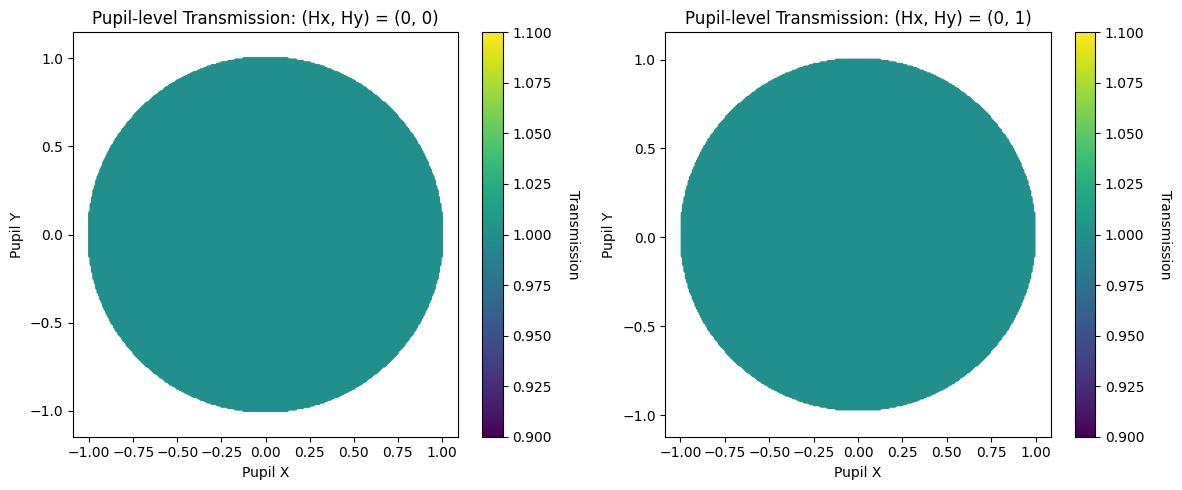

In [4]:
plot_transmission(lens)

These plots are not very interesting, because the transmission is 1 for all rays. This is the default behavior. Note that we ignore the slight variations in absorption due to path length during plotting, for visualization purposes only.

Let's now assign Fresnel coatings to all surfaces, which will enable us to simulate the behavior of our optic if all lenses are uncoated. We can do this easily using the "set_fresnel_coatings" method as follows:

In [5]:
lens.surface_group.set_fresnel_coatings()

Before we can assess the polarization impact, we must also set our polarization state. As mentioned, the lens defaults to ignoring polarization, which we can see by printing the lens "polarization" attribute:

In [6]:
lens.polarization

'ignore'

Let's specify that the lens should use unpolarized light. This can be done using the PolarizationState class:

In [7]:
state = PolarizationState(is_polarized=False)
lens.set_polarization(state)

And we now see that the polarization attribute has changed:

In [8]:
lens.polarization

Unpolarized Light

Let's plot the transmission versus pupil position:

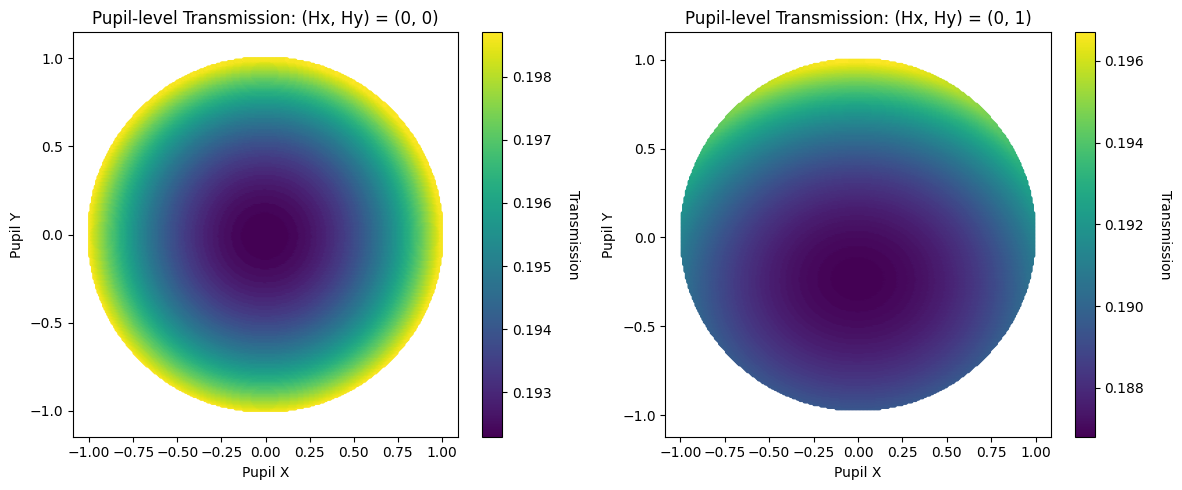

In [9]:
plot_transmission(lens)

This is much more interesting. Not only do we see a variation of nearly 1% across the pupil, but we also see a variation with field position.

Instead of using unpolarized light, we can also apply a specific polarization state. This is defined using the Jones vector approach, in which the electric field amplitude and phase are defined in the X and Y axes. Namely, we define

$E_x = E_{x, 0} \cdot e^{i\phi_x}$

$E_y = E_{y, 0} \cdot e^{i\phi_y}$

where $E_{x, 0}$ and $E_{y, 0}$ are the field amplitudes in x and y, respectively, and $\phi_x$ and $\phi_y$ are the phases.

This 2D formulation of the electric field is first converted into 3D based on the ray direction. The exact details of this conversion are out of the scope of this tutorial, but more information can be found in the code documentation.

We define these four components as follows. Note that for simplicity, we drop the "0" subscript of the amplitude.

In [10]:
Ex = 1
Ey = 0.5
phase_x = 0.2
phase_y = 0

state = PolarizationState(is_polarized=True, Ex=Ex, Ey=Ey, phase_x=phase_x, phase_y=phase_y)

lens.set_polarization(state)

### Testing polarization effects in Optiland
- Due to how Optiland considers polarization, it is only necessary to trace rays a single time before testing the system under different polarization states

We will demonstrate this behavior here. First, we trace a uniform grid of rays. The trace function returns the traced rays:

In [11]:
rays = lens.trace(Hx=0, Hy=0, wavelength=0.5875618, num_rays=256, distribution='uniform')

Now we can assign our previously-defined polarization state to the rays:

In [12]:
rays.update_intensity(state)

And as was done previously, we view the stop-level transmission for our specific polarization state:

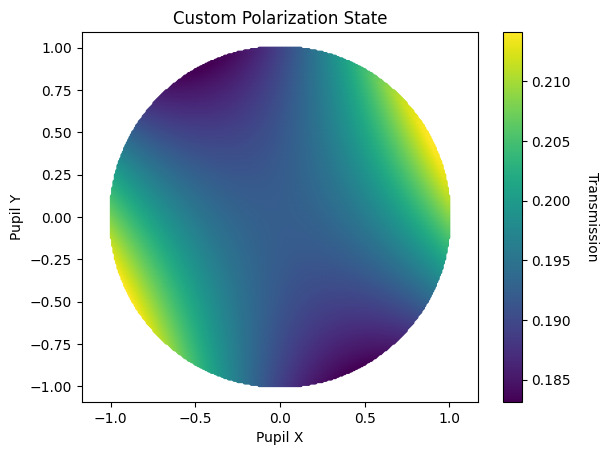

In [13]:
stop_idx = lens.surface_group.stop_index
x_stop = lens.surface_group.x[stop_idx, :]
y_stop = lens.surface_group.y[stop_idx, :]
r_max = np.max(np.sqrt(x_stop**2 + y_stop**2))
x_stop /= r_max
y_stop /= r_max

plt.scatter(x_stop, y_stop, c=rays.i, s=5)
plt.axis('equal')
plt.xlabel('Pupil X')
plt.ylabel('Pupil Y')
plt.title('Custom Polarization State')
cbar = plt.colorbar()
cbar.set_label('Transmission', rotation=270, labelpad=20)

Lastly, let's demonstrate how to quickly assess different polarization states without the need to re-trace rays.

Here, we make use of the "create_polarization" function, which generates the PolarizationState instance for common polarization types.

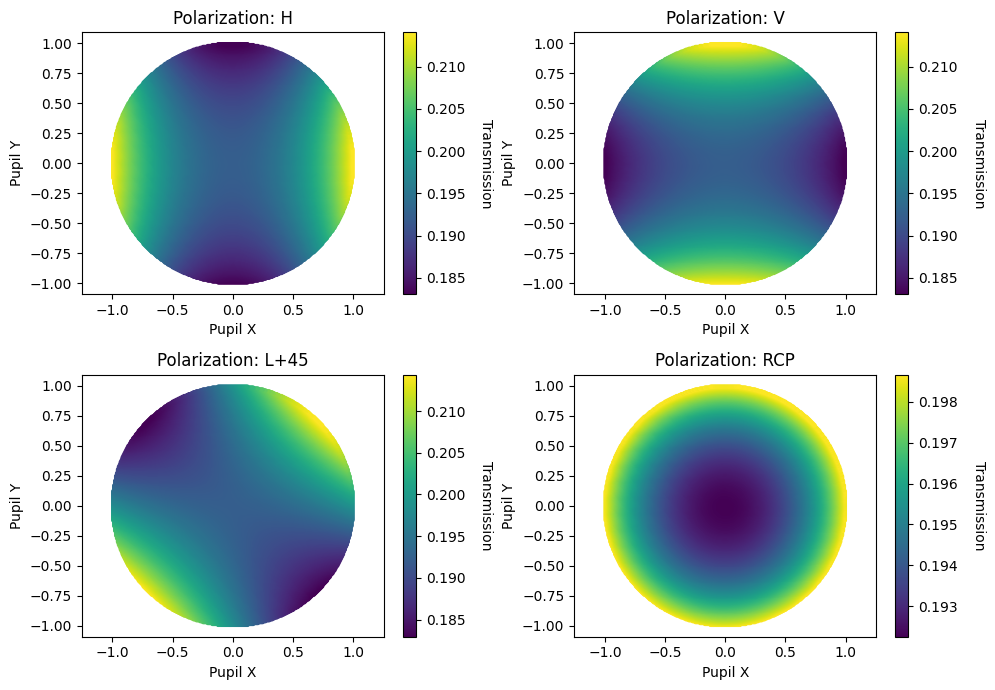

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(10, 7))

stop_idx = lens.surface_group.stop_index
x_stop = lens.surface_group.x[stop_idx, :]
y_stop = lens.surface_group.y[stop_idx, :]
r_max = np.max(np.sqrt(x_stop**2 + y_stop**2))
x_stop /= r_max
y_stop /= r_max

for i, pol_type in enumerate(['H', 'V', 'L+45', 'RCP']):
    state = create_polarization(pol_type)
    lens.set_polarization(state)
    rays.update_intensity(state)

    ax = axs[i // 2, i % 2]
    scatter = ax.scatter(x_stop, y_stop, c=rays.i, s=5)
    ax.axis('equal')
    ax.set_title(f'Polarization: {pol_type}')
    ax.set_xlabel('Pupil X')
    ax.set_ylabel('Pupil Y')
    
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Transmission', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

### Conclusions
- This tutorial demonstrated polarization functionality in Optiland.
- Optiland requires that rays only be traced once before various polarization types are assessed.

In future tutorials, we will expand on polarization topics, including waveplates, polarizing elements, and the Jones pupil.